# Doc 4 - Código para organização das imagens

Nessa documentação, meu trabalho foi voltado para encontrar uma forma de organizar de forma mais eficiente as imagens do dataset. Além de ter conseguido converter e salvar as imagens contidas no arquivo .dcm como .pgn, consegui também separá-las de acordo com seus diagnósticos, relacionando os arquivos .csv dos labels e das paths. Além disso, consegui também renomear as imagens, seguindo o padrão do ID do paciente e da orientação que a imagem foi gerada (lcc, lmlo, rcc, rmlo).

Para isso, baixei todo o test set da base dados (~135Gb, 1721 imagens).

É importante ressaltar que isso seria facilmente aplicável para os próprios arquivos .dcm.

In [14]:
#Imports 
import pydicom as dicom
import matplotlib.pylab as plt
import pandas as pd
import os
import numpy as np
from tabulate import tabulate
import tensorflow_io as tfio
import tensorflow as tf
import cv2
from collections import Counter
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_voi_lut
import shutil

Convém uma breve análise dos tipos de classes que estamos trabalhando.

In [2]:
labels = pd.read_csv(r"D:\Coisinhas\Coisas_UNB\TCC\dataset_dcm\test\manifest-1617905855234\BCS-DBT-labels-test-PHASE-2.csv") #Arquivo dos diagnosticos
labels.head()

,PatientID,StudyUID,View,Normal,Actionable,Benign,Cancer
0,DBT-P00882,DBT-S04273,lcc,0,0,0,1
1,DBT-P00882,DBT-S04273,lmlo,0,0,0,1
2,DBT-P01803,DBT-S04833,rcc,0,0,0,1
3,DBT-P01803,DBT-S04833,rmlo,0,0,0,1
4,DBT-P01183,DBT-S04722,rcc,0,0,0,1


In [3]:
labels[labels["Normal"] == 1].head(10)

,PatientID,StudyUID,View,Normal,Actionable,Benign,Cancer
365,DBT-P04126,DBT-S01217,lcc,1,0,0,0
366,DBT-P04126,DBT-S01217,lmlo,1,0,0,0
367,DBT-P04126,DBT-S01217,rcc,1,0,0,0
368,DBT-P04126,DBT-S01217,rmlo,1,0,0,0
369,DBT-P04126,DBT-S01626,lcc,1,0,0,0
370,DBT-P04126,DBT-S01626,lmlo,1,0,0,0
371,DBT-P04126,DBT-S01626,rcc,1,0,0,0
372,DBT-P04126,DBT-S01626,rmlo,1,0,0,0
373,DBT-P00590,DBT-S02537,lcc,1,0,0,0
374,DBT-P00590,DBT-S02537,lmlo,1,0,0,0


In [4]:
labels[labels["Actionable"] == 1].head(10)

,PatientID,StudyUID,View,Normal,Actionable,Benign,Cancer
121,DBT-P02941,DBT-S04870,lcc,0,1,0,0
122,DBT-P02941,DBT-S04870,lmlo,0,1,0,0
123,DBT-P02941,DBT-S04870,rcc,0,1,0,0
124,DBT-P02941,DBT-S04870,rmlo,0,1,0,0
125,DBT-P02609,DBT-S05243,lcc,0,1,0,0
126,DBT-P02609,DBT-S05243,lmlo,0,1,0,0
127,DBT-P02609,DBT-S05243,rcc,0,1,0,0
128,DBT-P02609,DBT-S05243,rmlo,0,1,0,0
129,DBT-P04439,DBT-S03719,lcc,0,1,0,0
130,DBT-P04439,DBT-S03719,lmlo,0,1,0,0


In [5]:
labels[labels["Benign"] == 1].head(10)

,PatientID,StudyUID,View,Normal,Actionable,Benign,Cancer
60,DBT-P00629,DBT-S01583,lcc,0,0,1,0
61,DBT-P00629,DBT-S01583,lmlo,0,0,1,0
62,DBT-P03430,DBT-S01182,lmlo,0,0,1,0
63,DBT-P01898,DBT-S02110,rcc,0,0,1,0
64,DBT-P01898,DBT-S02110,rmlo,0,0,1,0
65,DBT-P01497,DBT-S03809,lcc,0,0,1,0
66,DBT-P01497,DBT-S03809,lmlo,0,0,1,0
67,DBT-P01670,DBT-S01239,lcc,0,0,1,0
68,DBT-P01670,DBT-S01239,lmlo,0,0,1,0
69,DBT-P00794,DBT-S02871,lcc,0,0,1,0


In [6]:
labels[labels["Cancer"] == 1].head(10)

,PatientID,StudyUID,View,Normal,Actionable,Benign,Cancer
0,DBT-P00882,DBT-S04273,lcc,0,0,0,1
1,DBT-P00882,DBT-S04273,lmlo,0,0,0,1
2,DBT-P01803,DBT-S04833,rcc,0,0,0,1
3,DBT-P01803,DBT-S04833,rmlo,0,0,0,1
4,DBT-P01183,DBT-S04722,rcc,0,0,0,1
5,DBT-P01183,DBT-S04722,rmlo,0,0,0,1
6,DBT-P04982,DBT-S03578,rcc,0,0,0,1
7,DBT-P04982,DBT-S03578,rmlo,0,0,0,1
8,DBT-P01367,DBT-S02773,rcc,0,0,0,1
9,DBT-P01367,DBT-S02773,rmlo,0,0,0,1


Text(0.5, 1.0, 'Frequencia de categoria one hot no dataset de teste')

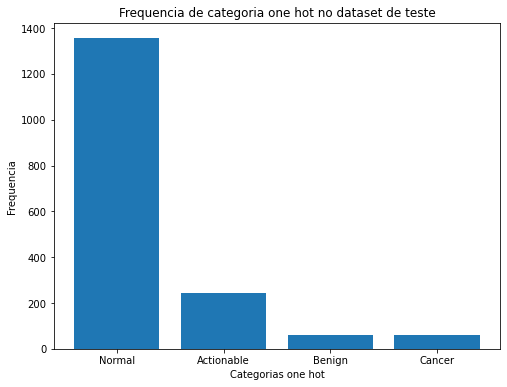

In [7]:
one_hot_sum = labels[['Normal', 'Actionable', 'Benign', 'Cancer']].sum()

plt.figure(figsize=(8, 6))

plt.bar(['Normal', 'Actionable', 'Benign', 'Cancer'], one_hot_sum)

plt.xlabel('Categorias one hot')
plt.ylabel('Frequencia')
plt.title('Frequencia de categoria one hot no dataset de teste')

C:\Users\breno\anaconda3\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


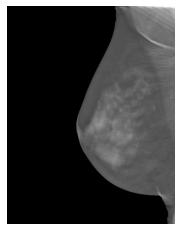

In [8]:
#Descobri que é possível converter as imagens dicom em .png.
#Fiz isso porque percebi que a memória que ocupam diminui consideravelmente.

def extract_and_save_image(dicom_file_path, output_image_path):
    #Leitura do .dcm
    ds = pydicom.dcmread(dicom_file_path)
    
    #Exração dos dados e aplicação de "VOI LUT"
    pixel_data = ds.pixel_array[0]
    pixel_data = apply_voi_lut(pixel_data, ds)
    
    #Plotar e salvar a imagem
    plt.imshow(pixel_data, cmap=plt.cm.gray)
    plt.axis('off')  # Hide axis
    plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)

dicom_file_path = r"D:\Coisinhas\Coisas_UNB\TCC\dataset_dcm\test\manifest-1617905855234\Breast-Cancer-Screening-DBT\DBT-P00004\01-01-2000-DBT-S03764-MAMMO screening digital bilateral-73497\11920.000000-70893\1-1.dcm"
output_image_path = 'output_image.png'
extract_and_save_image(dicom_file_path, output_image_path)


"The Value Of Interest(VOI) LUT transformation transforms the modality pixel values into pixel values which are meaningful for the user or the application".

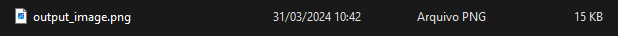

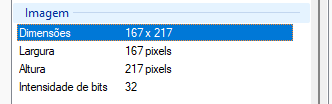

Essa não é a forma mais eficiente e não parece ser a melhor, pois o tamanho da imagem foi reduzido consideravelmente quando comparamos com as dimensões analisadas nas documentações passadas. Apesar disso, foi bom para descobrir que é possível essa conversão.

In [9]:
#Aqui novamente fiz o rename dos folders por conta do problema anterior.
root_dir = r"D:\Coisinhas\Coisas_UNB\TCC\dataset_dcm\test\manifest-1617905855234\Breast-Cancer-Screening-DBT"

#Acha o folder
for foldername, subfolders, filenames in os.walk(root_dir):
    for subfolder in subfolders:
        #Checa se tem o "-NA", que era o que tinha de diferente
        if '-NA' in subfolder:
            #Tira o "-NA" e deixa vazio colcando ''
            new_subfolder = subfolder.replace('-NA', '')
            old_path = os.path.join(foldername, subfolder)
            new_path = os.path.join(foldername, new_subfolder)
            #Faz o rename
            os.rename(old_path, new_path)

A partir disso, é agora possível "andar" pelo folders das imagens baixadas do dataset com facilidade e automatizar o processo de separação das imagens em seus labels e renomeá-las para fácil entendimento de qual paciente está sendo analisado e qual é o "view" da imagem.

In [13]:
#Ler os csvs das paths e da classificao de cada imagem
df_descriptive = pd.read_csv(r"D:\Coisinhas\Coisas_UNB\TCC\dataset_dcm\test\manifest-1617905855234\BCS-DBT-file-paths-test-v2.csv")
df_classification = pd.read_csv(r"D:\Coisinhas\Coisas_UNB\TCC\dataset_dcm\test\manifest-1617905855234\BCS-DBT-labels-test-PHASE-2.csv")

#Essa path é para adicionar antes da descriptive_path para ele achar as imagens no meu PC
additional_path = r"D:\Coisinhas\Coisas_UNB\TCC\dataset_dcm\test\manifest-1617905855234" 

#Local que serão salvas as imagens do test set
data_folder = r"D:\Coisinhas\Coisas_UNB\TCC\dataset_png\test"
#os.makedirs(data_folder, exist_ok=True)

#Folder das classes
class_folders = ['normal', 'actionable', 'benign', 'cancer']
for folder in class_folders:
    os.makedirs(os.path.join(data_folder, folder), exist_ok=True)
    

#Vai olhando os folders a partir da descriptive_path junto com a path do meu PC
for index, row in df_descriptive.iterrows():
    descriptive_path = os.path.join(additional_path, row['descriptive_path'])
    patient_id = row['PatientID'] 
    view = row['View']
    
    #Pega o dicom
    ds = pydicom.dcmread(descriptive_path)
    
    #Normalização dos pixels (0 -> 255), pois como já vimos têm valores muito altos. Se não forem normalizados, as imagens salvas são completamente pretas.
    pixel_array = ds.pixel_array[0]
    pixel_array = pixel_array.astype(np.float32)
    pixel_array -= np.min(pixel_array)
    pixel_array /= np.max(pixel_array)
    pixel_array *= 255
    pixel_array = pixel_array.astype(np.uint8)
    
    #Converte para .png
    image = Image.fromarray(pixel_array)
    
    #Classificacao das imagens a partir das informacoes do .csv
    #Faz um "novo" dataset a partir das informacoes
    classification_row = df_classification[(df_classification['PatientID'] == patient_id) & (df_classification['StudyUID'] == row['StudyUID']) & (df_classification['View'] == view)]
    
    #Relaciona as informacoes do "novo" dataset com as infos do dataset de classificacoes para colocar na pasta certa
    classification = classification_row.iloc[0]['Normal'], classification_row.iloc[0]['Actionable'], classification_row.iloc[0]['Benign'], classification_row.iloc[0]['Cancer']
    
    #Salva as imagens na classificacao correta e nomeia a partir do patient_id e view.
    class_folder = class_folders[classification.index(1)]
    image_name = f"{patient_id}_{view}.png"
    image.save(os.path.join(data_folder, class_folder, image_name))


C:\Users\breno\anaconda3\lib\site-packages\pydicom\pixel_data_handlers\pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (10-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(


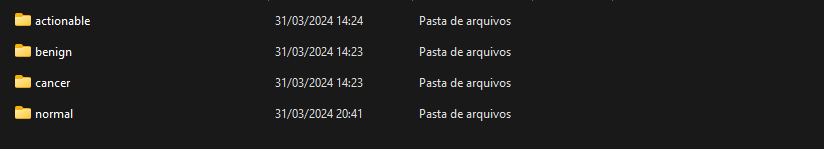

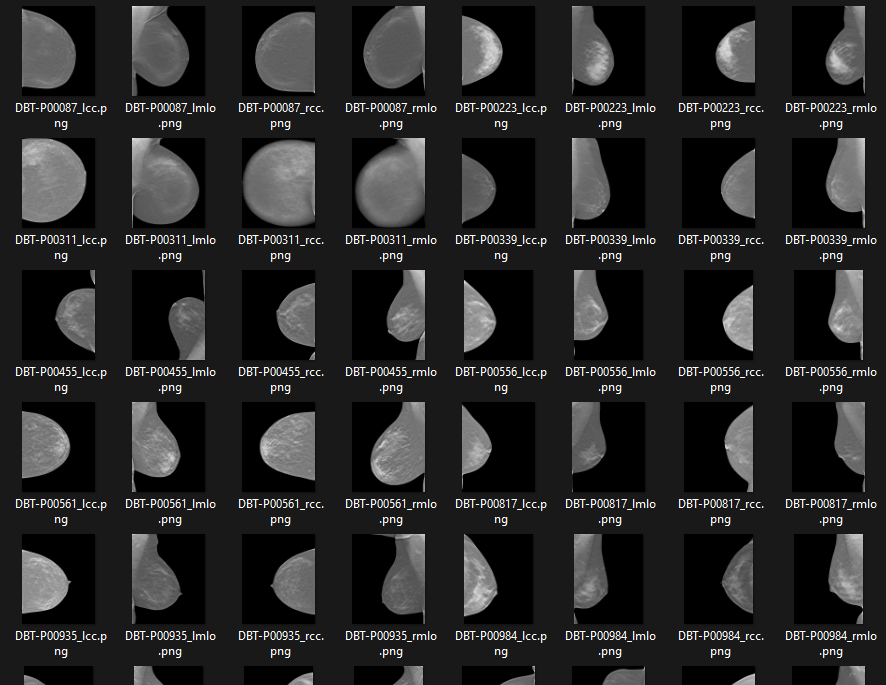